# Continuous Normalizing Flows for Nambu-Goto string

If this code is useful for your research, please cite us:


In [ ]:
pip install git+https://github.com/rtqichen/torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-jgiutxp0
  Running command git clone --filter=blob:none --quiet https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-jgiutxp0
  Resolved https://github.com/rtqichen/torchdiffeq to commit d6ee52b349ddb6f7ba4a114a65fd8783db243ed6
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import math
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [ ]:
from torchdiffeq import odeint_adjoint as odeint

In [ ]:
def grab(var):
    if torch.is_tensor(var):
        return var.detach().cpu().numpy()
    else:
        return var

In [ ]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cuda


# Prior

The prior used in our work is a Normal distribution.

In [ ]:
class Prior:
  def __init__(self,L,R,sd):
    self.V=L*R
    self.sd=sd
  def sample_n(self, batch):
    z=torch.Tensor(self.sd*np.random.randn(batch,self.V))
    return z
  def log_prob(self,z):
    logz=z**2/(2*self.sd**2)
    logz+=0.5*torch.log(torch.Tensor([2.0*torch.pi*self.sd**2]))
    return -logz.sum(-1)


# Target

The target theory is the Nambu-Goto string regularized on a bidimensional lattice $\Lambda$ with lattice step $a=1$ and sizes $|L\times R|$:
$$S[\phi]=\sigma\sum_{x\in \Lambda}\biggl(\sqrt{1+(\partial_\mu\phi)^2/σ}-1 \biggr)$$
where $\sigma$ is the string tension, and:
$$(\partial_\mu\phi)^2=\sum_{\mu=1}^2\bigl(\phi(x)-\phi(x-\hat{\mu})\bigr)^2$$
where $\hat{\mu}$ is a unit vector pointing the worldsheet coordinates $(\tau,\epsilon)$.

We fixed periodic boundary conditions along $L$ and Dirchilet along $R$.

Since the Dirichlet boundary are fixed, the "active" volume of the lattices generated by the CNFs is $|L\times (R-1)|$

In order to use the Dirichlet boundary conditions, we add a zero padding $\epsilon=R$, we then use periodic boundary conditions to obtain the Dirichlet boundary in $\epsilon=0$

In [ ]:
dir=torch.nn.ZeroPad2d((0,1,0,0))     
def S(cfgs,sigma):
  cfgs=dir(cfgs)
  act=(cfgs-torch.roll(cfgs,1,1))**2+(cfgs-torch.roll(cfgs,1,2))**2
  act=(torch.sqrt(1+act/sigma)-1).sum((1,2))
  return sigma*act

# CNF

The CNFs used in our work use a linear, continuous in time, vector field:
$$\frac{d\phi(t)_x}{dt}=\sum_{y,d}K(t)_dW_{d,x,y}\phi(t)_y$$
where $x$ and $y$ represents the active sites of the lattices and the temporal $K(t)\in \mathbb{R}^D$ is inspired by: [Learning Lattice Quantum Field Theories with Equivariant Continuous Flows](https://arxiv.org/abs/2207.00283).


$K(t)$:

In [ ]:
def cos_base(mode,t,T):
  return torch.cos(2.0*torch.pi*t*mode/T)

def sin_base(mode,t,T):
  return torch.sin(2.0*torch.pi*t*mode/T)

def make_K(t,T,D):
  return torch.hstack((torch.tensor([1.0]),cos_base(torch.arange(1,(D-1)/2+1,1),t,T),sin_base(torch.arange(1,(D-1)/2+1,1),t,T)))

Vector Field:

In [ ]:
class G(torch.nn.Module):
    def __init__(self,T,L,R,D):
        super().__init__()
        self.T=T
        self.D=D
        self.w = torch.nn.Parameter(torch.zeros(L*R,L*R,D))  #Identity initialization

    def forward(self,t,data):
        z, logz = data[0], data[1]
        K=make_K(t,self.T,self.D)
        dlogP=torch.ones(z.shape[0])*torch.diag(torch.matmul(self.w,K)).sum(-1)
        dx=torch.matmul(z,torch.matmul(self.w,K))
        return dx, -dlogP


## Training of the CNFs

In [ ]:
T=1.0
L=20
R=19 
sigma=100.0
D=3

In [ ]:
g=G(T,L,R,D).to(torch_device)

In [ ]:
sd=0.5

In [ ]:
prior = Prior(L,R,sd)

In [ ]:
dt=0.08

In [ ]:
times=torch.arange(0,T+dt,dt)
times.shape

torch.Size([14])

In [ ]:
def compute_metrics(w):
    N = len(w)
    logZ = logsumexp(-w)
    log_ess = 2.0 * logZ - logsumexp(-2 * w)
    ess_per_cfg = np.exp(log_ess) / N
    logZ = logZ - np.log(N)
    return ess_per_cfg, -logZ

In [ ]:
history={'loss':[],'ESS':[]}

In [ ]:
n_epochs=1000
batch_size=10000

In [ ]:
optimizer = torch.optim.Adam(g.parameters(), lr=0.0005,betas=(0.8,0.9))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
for t in tqdm(range(n_epochs)):
    # Forward pass: Compute predicted y by passing x to the model
    optimizer.zero_grad()
    x = prior.sample_n(batch_size)
    logx=prior.log_prob(x)

    ##ODE integration
    x,logx = odeint(g,(x,logx),times,method='rk4')
    
    # Compute and print loss and metrics
    s=S(x[-1].reshape((-1,L,R)),sigma)     
    w = logx[-1]+s
    loss=w.mean()
    ess,betaF=compute_metrics(grab(w))
    history['loss'].append(grab(loss))
    history['ESS'].append(ess)
    print(t, grab(loss), betaF, ess, grab(w.var()))
    #Backward
    loss.backward()
    optimizer.step()
    scheduler.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

0 -86.82756 -106.25206960116834 0.00012609782610518237 45.66518
1 -86.92638 -104.03109181796522 0.00032280887982763734 45.469017
2 -87.13946 -105.65571034823866 0.00011015579146549945 44.76144
3 -87.25635 -108.28502095614881 0.00010039138893383475 44.18797
4 -87.51955 -104.88179982577772 0.00014675894367247887 44.739513
5 -87.5196 -103.76490987216444 0.0001452994659357536 44.02183
6 -87.81665 -105.97856343661756 0.0002143654766234166 44.090572
7 -87.9815 -106.17347920810194 0.00024685742248465974 44.07949
8 -88.39277 -105.85034383212538 0.00026269416859668967 43.83926
9 -88.33952 -105.78120625888319 0.0001571157712542122 43.144558
10 -88.53318 -104.52221883212538 0.00024337166042137689 41.60467
11 -88.82834 -104.81441701327772 0.00025212218681943316 41.996807
12 -88.94891 -107.37027944003553 0.00023095469773545395 43.512188
13 -89.15948 -106.51114858066053 0.00019964907036983259 41.869957
14 -89.33384 -106.75804341708631 0.00023885751616323429 41.83926
15 -89.62407 -106.0698567715785 0

In [ ]:
#Learning Curve

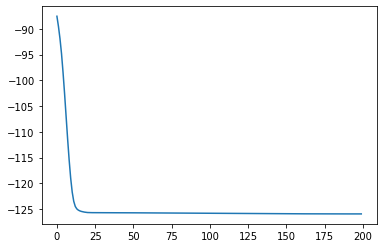

In [ ]:
#Loss
varbF=np.asarray(history['loss'])
plt.plot(varbF.reshape((int(n_epochs/10),10)).mean(-1)) 

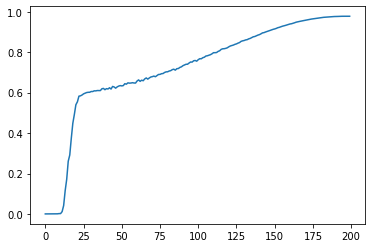

In [ ]:
#ESS
ESS=np.asarray(history['ESS'])
plt.plot(ESS.reshape((int(n_epochs/10),10)).mean(-1))

In [ ]:
#Simple test of \beta\hat{F} and ESS for 50k samples 

In [ ]:
z = prior.sample_n(50000)
logz=prior.log_prob(z)
x,logx = odeint(g,(z,logz),times,method='rk4')

In [ ]:
s=S(x[-1].reshape((-1,L,R)),sigma)
w = logx[-1]+s

In [ ]:
ess,bF=compute_metrics(grab(w))

In [ ]:
ess

0.9777746660396875

In [ ]:
bF

-125.92524735035533